# FV scheme
A finite volume scheme applied to the incompressible Navier Stokes equations

In [112]:
%matplotlib inline
# possible options: notebook, inline or widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.animation
import math 

In [113]:
def avg(A,axis=0):
    """
    Averaging function to go from cell centres (pressure nodes)
    to cell corners (velocity nodes) and vice versa.
    avg acts on index idim; default is idim=1.
    """
    if (axis==0):
        B = (A[1:,] + A[0:-1,])/2.
    elif (axis==1):
        B = (A[:,1:] + A[:,0:-1])/2.
    else:
        raise ValueError('Wrong value for axis')
    return B           

def DD(n,h):
    """
    One-dimensional finite-difference derivative matrix 
    of size n times n for second derivative:
    h^2 * f''(x_j) = -f(x_j-1) + 2*f(x_j) - f(x_j+1)

    Homogeneous Neumann boundary conditions on the boundaries 
    are imposed, i.e.
    f(x_0) = f(x_1) 
    if the wall lies between x_0 and x_1. This gives then
    h^2 * f''(x_j) = + f(x_0) - 2*f(x_1) + f(x_2)
                   = + f(x_1) - 2*f(x_1) + f(x_2)
                   =              f(x_1) + f(x_2)

    For n=5 and h=1 the following result is obtained:
 
    A =
        -1     1     0     0     0
         1    -2     1     0     0
         0     1    -2     1     0
         0     0     1    -2     1
         0     0     0     1    -1
    """
    # data = np.concatenate( (np.array(...), np.ones( (n-2,1) ) @ np.array(....),np.array(....)))
    # diags = np.array(.....)
    # A = sp.spdiags(data.T, diags, n, n) / h**2
    
    data = np.array([np.ones(n)*2/-h**2,np.ones(n)/h**2,np.ones(n)/h**2])
    data[0][0] = -1/h**2
    data[0][-1] = -1/h**2
    diags = np.array([0,-1,1])
    A=sp.spdiags(data, diags, n,n)

    return A
    
# DD(5,1).toarray()

Homemade version of Matlab tic and toc functions

In [114]:
def tic():
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

parameters of simulation

In [194]:
Pr = 0.71
Re = 20
# Ri = 0.
dt = 0.001 #unstable at 0.006
Tf = 20
Lx = 1.
Ly = 1.
Nx = 30
Ny = 30
namp = 0.
ig = 200
Nit = 1

flowcase = "C4"
if   flowcase[0] == "A": Re = 20;   Nx = 30;  Ny = 30
elif flowcase[0] == "B": Re = 200;  Nx = 50;  Ny = 50
elif flowcase[0] == "C": Re = 4000; Nx = 100; Ny = 100
elif flowcase[0] == "E": Re = 100;  Nx = 100; Ny = 100; Nit = 10000
elif flowcase == "C3adjusted": Re = 4000; Nx = 20; Ny = 20
if flowcase[1] == "1": Nit = 1
if flowcase[1] == "2": Nit = 10000
if flowcase[1] == "3": Nit = 50000
if flowcase[1] == "4": Nit = 160000; dt = 0.002

# edge coordinates
x = np.linspace(0,Lx,Nx+1)
y = np.linspace(0,Ly,Ny+1)
# grid spacing
hx = Lx/Nx
hy = Ly/Ny

boundary conditions

In [195]:
# boundary conditions
Utop = 1.
# Ttop = 1.
# Tbottom = 0.

uN = x*0 + Utop
uN = uN[:,np.newaxis]
vN = avg(x)*0
vN = vN[:,np.newaxis]

uS = x*0# + Utop
uS = uS[:,np.newaxis]
vS = avg(x)*0
vS = vS[:,np.newaxis]

uW = avg(y)*0
uW = uW[np.newaxis,:]
vW = y*0 #+ Utop
vW = vW[np.newaxis,:]

uE = avg(y)*0
uE = uE[np.newaxis,:]
vE = y*0 #+ Utop
vE = vE[np.newaxis,:]

# tN = ......
# tS = ......

Pressure correction and pressure Poisson equation

In [196]:
# Compute system matrices for pressure 
# Laplace operator on cell centres: Fxx + Fyy
# First set homogeneous Neumann condition all around
Lp = np.kron(sp.eye(Ny).toarray(),DD(Nx,hx).toarray()) + np.kron(DD(Ny,hy).toarray(),sp.eye(Nx).toarray())

In [198]:
# Set one Dirichlet value to fix pressure in that point
Lp[:,0] = 0 # ?
Lp[0,:] = 0 # ?
Lp[0,0] = 1 # ?
Lp_lu, Lp_piv = scl.lu_factor(Lp)
Lps = sp.csc_matrix(Lp)
Lps_lu = splu(Lps)

Initial conditions

In [199]:
U = np.zeros((Nx-1,Ny))
V = np.zeros((Nx,Ny-1))
# T = .... + namp*(np.random.rand(Nx,Ny)-0.5)

Main time-integration loop. Write output file "cavity.mp4" if 

In [200]:
# if (ig>0):
#     metadata = dict(title='Lid-driven cavity', artist='SG2212')
#     writer = matplotlib.animation.FFMpegWriter(fps=15, metadata=metadata)
#     matplotlib.use("Agg")
#     fig=plt.figure()
#     writer.setup(fig,"cavity.mp4",dpi=200)
# Nit = 1

# Question 2 and 4:
ucenter = np.zeros(Nit)
time = np.linspace(0,Nit-1,Nit)
# vmax = 0

# progress bar
print('[         |         |         |         |         ]')
tic()
for k in range(Nit):
    # print("Iteration k=%i time=%.2e" % (k,k*dt))
    # include all boundary points for u and v (linear extrapolation
    # for ghost cells) into extended array (Ue,Ve)
    Ue = np.vstack((uW, U, uE))
    Ue = np.hstack( (2*uS-Ue[:,0,np.newaxis], Ue, 2*uN-Ue[:,-1,np.newaxis]))
    Ve = np.hstack((vS, V, vN))
    Ve = np.vstack( (2*vW-Ve[0,np.newaxis,:], Ve, 2*vE-Ve[-1,np.newaxis, :]))

    # averaged (Ua,Va) of u and v on corners
    Ua = avg(Ue, 1)
    Va = avg(Ve, 0)

    # construct individual parts of nonlinear terms
    dUVdx = np.diff(Ua*Va,1,0)/hx # element wise product using * operator, np.multiply also possible
    dUVdy = np.diff(Ua*Va,1,1)/hy # element wise product using * operator
    # take U and V from the correct position in the grid,
    # as Ua, Va are averaged along wrong axes:
    Ub    = avg(Ue[:,1:-1],0) 
    Vb    = avg(Ve[1:-1,:],1)
    dU2dx = np.diff( Ub*Ub,1,0 )/hx # element wise product using * operator
    dV2dy = np.diff( Vb*Vb,1,1 )/hy # element wise product using * operator

    # treat viscosity explicitly
    viscu = np.diff( Ue[:,1:-1] , axis=0,n=2 )/hx**2 + np.diff( Ue[1:-1,:] , axis=1,n=2 )/hy**2
    viscv = np.diff( Ve[:,1:-1] , axis=0,n=2 )/hx**2 + np.diff( Ve[1:-1,:] , axis=1,n=2 )/hy**2

    # compose final nonlinear term + explicit viscous terms
    U = U - dt*(dUVdy[1:-1,:] + dU2dx) + dt/Re*viscu 
    V = V - dt*(dUVdx[:,1:-1] + dV2dy) + dt/Re*viscv 
 
    # pressure correction, Dirichlet P=0 at (1,1)
    rhs = (np.diff( np.vstack( (uW, U, uE)),n=1,axis=0)/hx + np.diff( np.hstack( (vS, V, vN)),n=1,axis=1)/hy )/dt
    rhs = np.reshape(rhs.T,(Nx*Ny,1))
    rhs[0] = 0

    # different ways of solving the pressure-Poisson equation:
    P = Lps_lu.solve(rhs)
    P = np.reshape(P.T,(Ny,Nx)).T
    
    # apply pressure correction
    U = U - dt*np.diff(P, axis=0, n=1)/hx
    V = V - dt*np.diff(P, axis=1, n=1)/hy

    # Question 2 and 4:
    # vmax1 = max(map(max, Ve))
    # if vmax1 > vmax:
    #     vmax = vmax1
    ucenter[k]= U[int(np.ceil(Nx/2)),int(np.ceil(Ny/2))]

    # Temperature equation
    # ....

    # do postprocessing to file
    # if (ig>0 and np.floor(k/ig)==k/ig):
    #     plt.clf()
    #     plt.contourf(avg(x),avg(y),T.T,levels=np.arange(0,1.05,0.05))
    #     plt.gca().set_aspect(1.)
    #     plt.colorbar()
    #     plt.title(f'Temperature at t={k*dt:.2f}')
    #     writer.grab_frame()


    # update progress bar
    if np.floor(51*k/Nit)>np.floor(51*(k-1)/Nit): 
        print('.',end='')


# finalise progress bar
print(' done. Iterations k=%i time=%.2f' % (k,k*dt))
toc()

# print(vmax)

# if (ig>0):
#     writer.finish()

[         |         |         |         |         ]
................................................... done. Iterations k=159999 time=320.00
Elapsed time is 1215.130226612091 seconds.


Visualisation of the flow field + divergence at the end time:

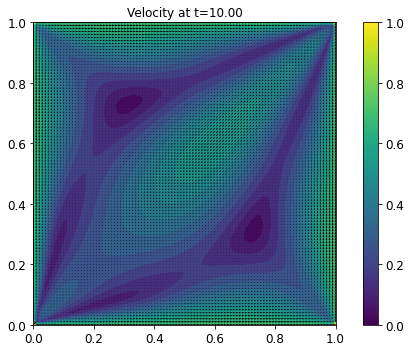

In [172]:
Ua = np.hstack( (uS,avg(np.vstack((uW,U,uE)),1),uN))
Va = np.vstack( (vW,avg(np.hstack((vS,V,vN)),0),vE))
# flowcase = "E2"
plt.figure()
plt.contourf(x,y,np.sqrt(Ua**2+Va**2).T,20)
plt.quiver(x,y,Ua.T,Va.T)
plt.gca().set_aspect(1.)
plt.colorbar()
plt.title(f'Velocity at t={k*dt:.2f}')
plt.tight_layout()
plt.savefig("plots/vel"+flowcase+".pdf")
# plt.show()

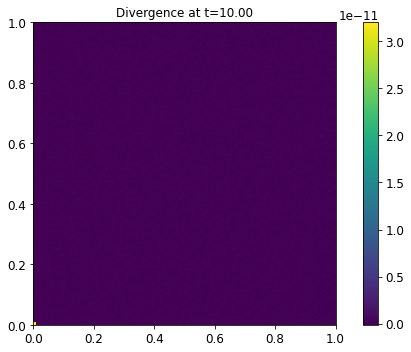

In [173]:
div = (np.diff( np.vstack( (uW,U, uE)),axis=0)/hx + np.diff( np.hstack(( vS, V, vN)),axis=1)/hy)
plt.figure()
plt.pcolor(avg(x),avg(y),div.T,shading='nearest')
plt.gca().set_aspect(1.)
plt.colorbar()
plt.title(f'Divergence at t={k*dt:.2f}')
plt.tight_layout()
plt.savefig("plots/div"+flowcase+".pdf")
# plt.show()

Velocity-time plot at center point

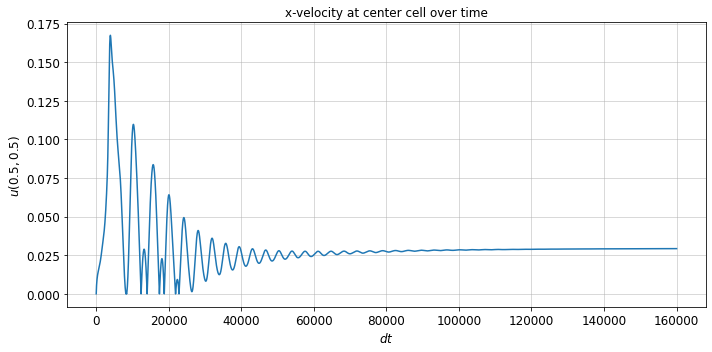

In [201]:
plt.figure(figsize=(10,5))
plt.plot(time, abs(ucenter))
plt.ylabel("$u(0.5,0.5)$")
plt.xlabel("$dt$")
plt.title("x-velocity at center cell over time")
plt.grid()
plt.tight_layout()
plt.savefig("plots/ucenter"+flowcase+".pdf")
# plt.show()

## Analysis of the pressure Poisson equation:

Matrix structure:

In [ ]:
plt.figure()
plt.spy(Lp)
plt.show()

Size, rank and null space:

In [ ]:
Lp.shape

In [ ]:
np.linalg.matrix_rank(Lp)

In [ ]:
scl.null_space(Lp)